## Compiling into Booleans and Calling SAT-solver

The following code is an adaptation of the OR-Tools tutorial for SAT-solving the N-Queens problem.

The original tutorial does not compile the variables into booleans and our approach does as intended.

In [12]:
import sys
import time
from ortools.sat.python import cp_model

In [13]:
board_size=int(input())

This class is to override the OR-Tools API to print the desired solution.

In [14]:
class NQueenSolutionPrinter(cp_model.CpSolverSolutionCallback):
    """Print intermediate solutions."""

    def __init__(self, queens: list[list[cp_model.BoolVarT]],sig=False):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__queens = queens
        self.__solution_count = 0
        self.__start_time = time.time()
        self.sig=sig

    @property
    def solution_count(self) -> int:
        return self.__solution_count

    def on_solution_callback(self):
        if self.sig:
            self.stop_search()
        else:
            current_time = time.time()
            print(
                f"Solution {self.__solution_count}, "
                f"time = {current_time - self.__start_time} s"
            )

            all_queens = range(len(self.__queens))
            for i in all_queens:
                for j in all_queens:
                    if self.value(self.__queens[j][i]):
                        # There is a queen in column j, row i.
                        print("Q", end=" ")
                    else:
                        print("_", end=" ")
                print()
            print()

In [15]:
model = cp_model.CpModel()

Compiling the variables into booleans: each cell of the board is a boolean for the presence of a queen.

In [16]:
# There are `board_size` number of variables, one for a queen in each column
# of the board. The value of each variable is the row that the queen is in.
queens=[]
for i in range(board_size):
    queens.append([])
    for j in range(board_size):
        queens[i].append(model.new_bool_var(f"x_{i}_{j}"))


The constraint formulation is harder for a boolean compiled SAT Problem than to a regular constraint problem, due to row/column/diagonal index proprerties not being obvious to leverage.

There are explicit constraints for every diagonal in a square matrix in the following code.

In [17]:
# Row constraints: exactly one queen per row
for i in range(board_size):
    model.AddExactlyOne(queens[i])

# Column constraints: exactly one queen per column
for j in range(board_size):
    model.AddExactlyOne(queens[i][j] for i in range(board_size))

# Main diagonal constraints (i - j constant)
for d in range(-(board_size - 1), board_size):
    model.AddAtMostOne(
        queens[i][j] for i in range(board_size) for j in range(board_size) if i - j == d
    )

# Anti-diagonal constraints (i + j constant)
for d in range(2 * board_size - 1):
    model.AddAtMostOne(
        queens[i][j] for i in range(board_size) for j in range(board_size) if i + j == d
    )


Finally we call the SAT-solver, print the solutions and some statistics.

In [18]:
# Solve the model.
solver = cp_model.CpSolver()
solution_printer = NQueenSolutionPrinter(queens)
solver.parameters.enumerate_all_solutions = True
solver.solve(model, solution_printer)

Solution 0, time = 0.013901710510253906 s
_ _ _ _ _ _ _ Q 
_ Q _ _ _ _ _ _ 
_ _ _ Q _ _ _ _ 
Q _ _ _ _ _ _ _ 
_ _ _ _ _ _ Q _ 
_ _ _ _ Q _ _ _ 
_ _ Q _ _ _ _ _ 
_ _ _ _ _ Q _ _ 

Solution 0, time = 0.014489412307739258 s
_ _ _ _ _ _ Q _ 
_ Q _ _ _ _ _ _ 
_ _ _ Q _ _ _ _ 
Q _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ Q 
_ _ _ _ Q _ _ _ 
_ _ Q _ _ _ _ _ 
_ _ _ _ _ Q _ _ 

Solution 0, time = 0.015122652053833008 s
_ _ _ Q _ _ _ _ 
_ _ _ _ _ _ Q _ 
_ _ Q _ _ _ _ _ 
_ _ _ _ _ _ _ Q 
_ Q _ _ _ _ _ _ 
_ _ _ _ Q _ _ _ 
Q _ _ _ _ _ _ _ 
_ _ _ _ _ Q _ _ 

Solution 0, time = 0.015481233596801758 s
_ _ _ Q _ _ _ _ 
Q _ _ _ _ _ _ _ 
_ _ _ _ Q _ _ _ 
_ _ _ _ _ _ _ Q 
_ Q _ _ _ _ _ _ 
_ _ _ _ _ _ Q _ 
_ _ Q _ _ _ _ _ 
_ _ _ _ _ Q _ _ 

Solution 0, time = 0.015758514404296875 s
_ _ _ Q _ _ _ _ 
Q _ _ _ _ _ _ _ 
_ _ _ _ Q _ _ _ 
_ _ _ _ _ _ _ Q 
_ _ _ _ _ Q _ _ 
_ _ Q _ _ _ _ _ 
_ _ _ _ _ _ Q _ 
_ Q _ _ _ _ _ _ 

Solution 0, time = 0.01606297492980957 s
_ _ Q _ _ _ _ _ 
_ _ _ _ _ Q _ _ 
_ _ _ Q _ _ _ _ 
Q _ _ _ _ _ _

4

In [19]:
# Statistics.
print("\nStatistics")
print(f"  conflicts      : {solver.num_conflicts}")
print(f"  branches       : {solver.num_branches}")
print(f"  wall time      : {solver.wall_time} s")
print(f"  solutions found: {solution_printer.solution_count}")


Statistics
  conflicts      : 1162
  branches       : 16108
  wall time      : 0.061083658000000006 s
  solutions found: 0


## Constraint Problem Solver

This implementation of a Constraint Problem Solver follows the OR-Tools tutorial for CP Solving the N-Queens problem.

In [20]:
import sys
from ortools.constraint_solver import pywrapcp

In [21]:
board_size=int(input())

In [22]:
solver = pywrapcp.Solver("n-queens")

In [23]:
# The array index is the column, and the value is the row.
queens = [solver.IntVar(0, board_size - 1, f"x{i}") for i in range(board_size)]

In [24]:
# All rows must be different.
solver.Add(solver.AllDifferent(queens))

# No two queens can be on the same diagonal.
solver.Add(solver.AllDifferent([queens[i] + i for i in range(board_size)]))
solver.Add(solver.AllDifferent([queens[i] - i for i in range(board_size)]))

In [25]:
db = solver.Phase(queens, solver.CHOOSE_FIRST_UNBOUND, solver.ASSIGN_MIN_VALUE)

In [26]:
# Iterates through the solutions, displaying each.
num_solutions = 0
solver.NewSearch(db)
while solver.NextSolution():
        # Displays the solution just computed.
    for i in range(board_size):
        for j in range(board_size):
            if queens[j].Value() == i:
                    # There is a queen in column j, row i.
                print("Q", end=" ")
            else:
                print("_", end=" ")
        print()
    print()
    num_solutions+=1
solver.EndSearch()

Q _ _ _ _ _ _ _ 
_ _ _ _ _ _ Q _ 
_ _ _ _ Q _ _ _ 
_ _ _ _ _ _ _ Q 
_ Q _ _ _ _ _ _ 
_ _ _ Q _ _ _ _ 
_ _ _ _ _ Q _ _ 
_ _ Q _ _ _ _ _ 

Q _ _ _ _ _ _ _ 
_ _ _ _ _ _ Q _ 
_ _ _ Q _ _ _ _ 
_ _ _ _ _ Q _ _ 
_ _ _ _ _ _ _ Q 
_ Q _ _ _ _ _ _ 
_ _ _ _ Q _ _ _ 
_ _ Q _ _ _ _ _ 

Q _ _ _ _ _ _ _ 
_ _ _ _ _ Q _ _ 
_ _ _ _ _ _ _ Q 
_ _ Q _ _ _ _ _ 
_ _ _ _ _ _ Q _ 
_ _ _ Q _ _ _ _ 
_ Q _ _ _ _ _ _ 
_ _ _ _ Q _ _ _ 

Q _ _ _ _ _ _ _ 
_ _ _ _ Q _ _ _ 
_ _ _ _ _ _ _ Q 
_ _ _ _ _ Q _ _ 
_ _ Q _ _ _ _ _ 
_ _ _ _ _ _ Q _ 
_ Q _ _ _ _ _ _ 
_ _ _ Q _ _ _ _ 

_ _ _ _ _ Q _ _ 
Q _ _ _ _ _ _ _ 
_ _ _ _ Q _ _ _ 
_ Q _ _ _ _ _ _ 
_ _ _ _ _ _ _ Q 
_ _ Q _ _ _ _ _ 
_ _ _ _ _ _ Q _ 
_ _ _ Q _ _ _ _ 

_ _ _ Q _ _ _ _ 
Q _ _ _ _ _ _ _ 
_ _ _ _ Q _ _ _ 
_ _ _ _ _ _ _ Q 
_ Q _ _ _ _ _ _ 
_ _ _ _ _ _ Q _ 
_ _ Q _ _ _ _ _ 
_ _ _ _ _ Q _ _ 

_ _ _ _ Q _ _ _ 
Q _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ Q 
_ _ _ Q _ _ _ _ 
_ Q _ _ _ _ _ _ 
_ _ _ _ _ _ Q _ 
_ _ Q _ _ _ _ _ 
_ _ _ _ _ Q _ _ 

_ _ Q _ _ _ _ _ 
Q _ _ _ _ _ _ _ 
_ _ _ _

In [27]:
 # Statistics.
print("\nStatistics")
print(f"  failures: {solver.Failures()}")
print(f"  branches: {solver.Branches()}")
print(f"  wall time: {solver.WallTime()} ms")
print(f"  Solutions found: {num_solutions}")


Statistics
  failures: 304
  branches: 790
  wall time: 58 ms
  Solutions found: 92


## Comparing Solvers

We now compare the different solutions to the N-Queen problem by assessing the function of running wall time for the first solution found over the number of queens.

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
solvers=['DFS','SAT-Solver','CP-Solver']
results={}
sat_time=[]
cp_time=[]


for i in range(1,31):
    #print(i)
    board_size=i

    solver = pywrapcp.Solver("n-queens")
    queens = [solver.IntVar(0, board_size - 1, f"x{i}") for i in range(board_size)]
    solver.Add(solver.AllDifferent(queens))
    solver.Add(solver.AllDifferent([queens[i] + i for i in range(board_size)]))
    solver.Add(solver.AllDifferent([queens[i] - i for i in range(board_size)]))
    db = solver.Phase(queens, solver.CHOOSE_FIRST_UNBOUND, solver.ASSIGN_MIN_VALUE)
    
    solver.NewSearch(db)
    solver.NextSolution()
    solver.EndSearch()
    cp_time.append(solver.WallTime())

    #------------------------------------


    model = cp_model.CpModel()
    queens=[]
    for i in range(board_size):
        queens.append([])
        for j in range(board_size):
            queens[i].append(model.new_bool_var(f"x_{i}_{j}"))
    for i in range(board_size):
        model.AddExactlyOne(queens[i])
    for j in range(board_size):
        model.AddExactlyOne(queens[i][j] for i in range(board_size))
    for d in range(-(board_size - 1), board_size):
        model.AddAtMostOne(
            queens[i][j] for i in range(board_size) for j in range(board_size) if i - j == d)
    for d in range(2 * board_size - 1):
        model.AddAtMostOne(queens[i][j] for i in range(board_size) for j in range(board_size) if i + j == d)
    solver = cp_model.CpSolver()
    solution_printer=NQueenSolutionPrinter(queens,True)
    solver.parameters.enumerate_all_solutions = False
    solver.solve(model, solution_printer)

    sat_time.append(solver.wall_time)



In [33]:
results['SAT-Solver']=sat_time
results['CP-Solver']=cp_time

#Hand Collected Data: zeros are due to values being lesser than printable long double precision.
results['DFS']=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000,0,3000,0,17000]

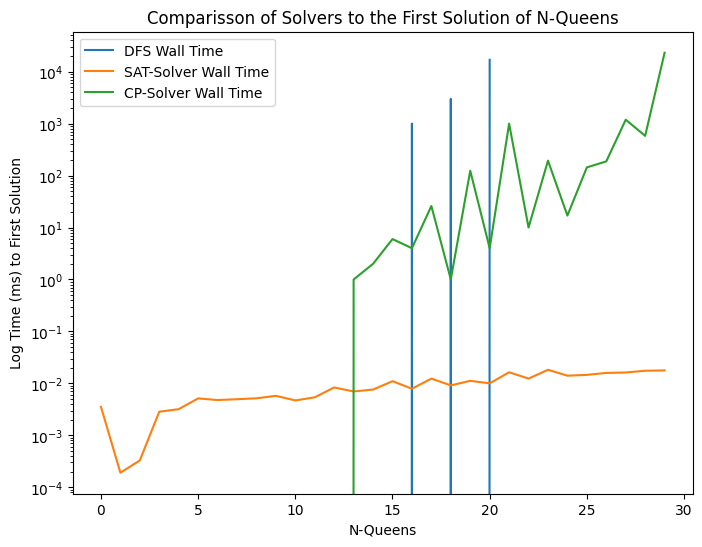

In [35]:
plt.figure(figsize=(8, 6))

for name in solvers:
      plt.plot(results[name], label=f'{name} Wall Time')
  
plt.xlabel('N-Queens')
plt.ylabel('Log Time (ms) to First Solution')
plt.yscale('log')
plt.title(f'Comparisson of Solvers to the First Solution of N-Queens')
plt.legend()
plt.show()